In [1]:
import pandas
import numpy as np

# for Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
# for Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
train_data_X = pandas.read_csv('train.csv', delimiter=',')
test_data_X  = pandas.read_csv('test.csv', delimiter=',')

test_data_X  = test_data_X.drop(columns=['Cabin', 'Ticket', 'PassengerId', 'Name'])
test_data_Y  = 0
train_data_Y = train_data_X['Survived']
train_data_X = train_data_X.drop(columns=['Cabin', 'Ticket', 'PassengerId', 'Name', 'Survived'])



important_features = ['Embarked', 'Sex', 'Pclass']

'''
    fillMissing: fill columns containing missing.
    Base on: Embarked, Sex, Pclass
    1. Filter rows whose features have the same value with the dealing with one   
'''


def quantization(data):

    for index, row in data.iterrows():
        # SibSp, Parch
        if row['SibSp'] > 1:
            data.at[row.name, 'SibSp'] = 2
        if row['Parch'] > 1:
            data.at[row.name, 'Parch'] = 2

        # Embarked
        if row['Embarked'] == 'S':
            data.at[row.name, 'Embarked'] = 0
        elif row['Embarked'] == 'C':
            data.at[row.name, 'Embarked'] = 1
        else:
            data.at[row.name, 'Embarked'] = 2

        # Sex
        if row['Sex'] == 'male':
            data.at[row.name, 'Sex'] = 1
        else:
            data.at[row.name, 'Sex'] = 2
            
#         #Age
#         if row['Age'] < 15:
#             data.at[row.name, 'Age'] = 1
#         elif row['Age'] < 35:
#             data.at[row.name, 'Age'] = 2
#         elif row['Age'] < 55:
#             data.at[row.name, 'Age'] = 3
#         else:
#             data.at[row.name, 'Age'] = 4


def fill_missing(data, feature):
    null_data = data[data[feature].isnull()]

    for index, row in null_data.iterrows():
        nulldata_Embarked = row['Embarked']
        nulldata_Sex      = row['Sex']
        nulldata_Pclass   = row['Pclass']

        series_null = 1
        for im_feature, nulldata_value in zip(important_features, [nulldata_Embarked, nulldata_Sex, nulldata_Pclass]):
            if im_feature != feature:
                series_null = series_null & (data[im_feature] == nulldata_value)

        filtered_column = (data.loc[series_null])[feature]
        data.at[row.name, feature] = filtered_column.mean()

In [9]:
quantization(data=train_data_X)
fill_missing(train_data_X, 'Fare')
fill_missing(train_data_X, 'Age')

quantization(test_data_X)
fill_missing(test_data_X, 'Fare')
fill_missing(test_data_X, 'Age')

In [10]:
scaler = MinMaxScaler()
scaler.fit(train_data_X)

/opt/anaconda/envs/Machine_Learning/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
# train_data_Xtransformed = scaler.transform(train_data_X)
# test_data_Xtransformed = scaler.transform(test_data_X)

train_data_Xtransformed = train_data_X.values
test_data_Xtransformed = scaler.transform(test_data_X)

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [18]:
# logreg = LogisticRegression(solver='lbfgs')
svm = SVC(kernel='rbf', C=10, gamma=0.1)
gbrt = GradientBoostingClassifier(random_state=37, learning_rate=0.1, n_estimators=5, max_depth=5)
print(cross_val_score(estimator=gbrt, X=train_data_Xtransformed, y=train_data_Y, cv=kfold).mean())

0.8035716527524952


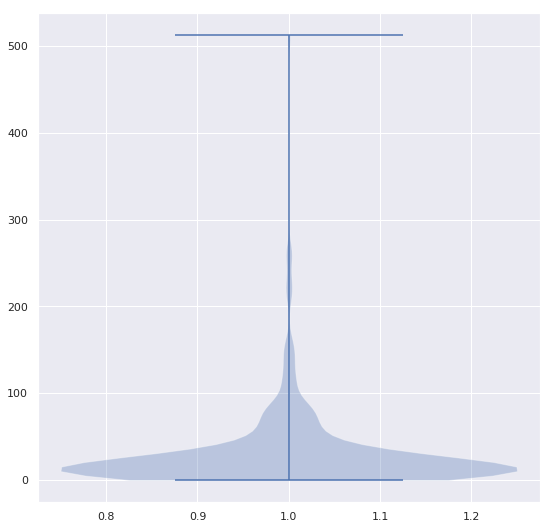

In [9]:
age = train_data_X['Fare'].values
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 9), sharey=True)
ax1.violinplot(age)
plt.show()